In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
paths = ['/home/qnicolas/iac_notebooks/tools/', '/home/qnicolas/stationaryWave']
for p in paths:
    if p not in sys.path:
        sys.path.append(p)
from generalTools import quickplot,wrap_lon, invert_latitudes
from mydedalustools import calc_helmholtz, open_h5s, concat_levels


import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

In [2]:
def add_wind(ax,u,v,scale=None,key=True,ref=1,unit='m/s',keypos=(0.93,0.95),nm=1):
    """Adds a quiver plot to a matplotlib axis"""
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=nm;m=nm
    Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=scale,transform=ccrs.PlateCarree())
    if key:
        ax.quiverkey(Q, *keypos, ref, label='%i %s'%(ref,unit), labelpos='E', coordinates='axes',color='k')


In [3]:
SP = xr.open_dataset("stationaryWave/ncep_jan_forcings.nc").SP

# Eddy geopotential and streamfunction in NCEP-NCAR

In [89]:
import dedalus.public as d3
def calc_helmholtz_ncep(u_xr):
    """Calculates a streamfunction and Helmholtz decomposition on reanalysis data output
    Here the streamfunction psi is defined such that laplacian(psi) = curl(u)
    args:
        - u_xr: xarray.DataArray
        Note u should not depend on time.
    returns:
        - xarray.Dataset with four variables: u_rot (rotational part of u), 
        u_div (divergent part of u), div (divergence of u), and psi (streamfunction)
    """
    meter = 1 / 6.37122e6 # To perform the numerical calculation, we rescale all lengths by Earth's radius 
    second = 1./3600

    dealias = (3/2,3/2)
    dtype = np.float64
    Nphi = len(u_xr.lon)
    Ntheta = len(u_xr.lat)
    
    coords = d3.S2Coordinates('phi', 'theta')
    dist = d3.Distributor(coords, dtype=dtype)
    basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=6.37122e6 * meter, dealias=dealias, dtype=dtype)
    
    # placeholder for u_rot and u_div
    u_xr = u_xr.transpose('','lon','lat')
    u_rot_xr = 0. * u_xr.rename('u_rot')
    u_div_xr = 0. * u_xr.rename('u_div')
    divu_xr = 0. * u_xr.isel({'':0}).rename('div')
    psi_xr  = 0. * u_xr.isel({'':0}).rename('psi')
        
    u = dist.VectorField(coords, name='u', bases=basis)
    u_rot = dist.VectorField(coords, name='u_rot', bases=basis)
    u_xr[1] = -u_xr[1] # flip the sign of the v-component because of the dedalus convention
    u.load_from_global_grid_data(u_xr.data * meter / second)
    
    c = dist.Field(name='c')
    psi = dist.Field(name='psi', bases=basis)
    problem = d3.LBVP([c, psi], namespace=locals())
    problem.add_equation("lap(psi) + c = - div(skew(u))")
    problem.add_equation("ave(psi) = 0")
    solver = problem.build_solver()
    solver.solve()
    
    u_rot = d3.skew(d3.grad(psi)).evaluate()
    divu = d3.div(u).evaluate()
    
    u.change_scales(1)
    u_rot.change_scales(1)
    divu.change_scales(1)
    psi.change_scales(1)
    
    psi_xr[:] = psi['g']
    u_rot_xr[:] = u_rot['g']
    u_div_xr[:] = u['g']-u_rot['g']
    divu_xr[:] = divu['g']
        
    return xr.merge((u_rot_xr / (meter/second), 
                     u_div_xr / (meter/second),
                     psi_xr / (meter**2 / second),
                     divu_xr / (1/second))).transpose('','lat','lon')

In [90]:
path = "/net/atmos/data/ncep/reanalysis"
target_dir = "/net/helium/atmosdyn/qnicolas/ncep_means"


In [91]:
ncep_jan_all_mean = xr.open_dataset(target_dir + "/ncep_jan_all_mean.nc")

In [92]:
Phiprime = ncep_jan_all_mean.Z - ncep_jan_all_mean.Z.mean('lon')

In [98]:
U_xr = invert_latitudes(xr.concat([ncep_jan_all_mean.U, ncep_jan_all_mean.V],dim='').sel(level=300))
helmhotz  = calc_helmholtz_ncep(U_xr)

2025-06-25 16:12:35,438 subsystems 0/1 INFO :: Building subproblem matrices 1/72 (~1%) Elapsed: 0s, Remaining: 1s, Rate: 8.5e+01/s
2025-06-25 16:12:35,483 subsystems 0/1 INFO :: Building subproblem matrices 8/72 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2025-06-25 16:12:35,534 subsystems 0/1 INFO :: Building subproblem matrices 16/72 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-06-25 16:12:35,585 subsystems 0/1 INFO :: Building subproblem matrices 24/72 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-06-25 16:12:35,636 subsystems 0/1 INFO :: Building subproblem matrices 32/72 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-06-25 16:12:35,687 subsystems 0/1 INFO :: Building subproblem matrices 40/72 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-06-25 16:12:35,739 subsystems 0/1 INFO :: Building subproblem matrices 48/72 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-06-25 16:12:35,790 subsystems 0/1 INFO :: Building subproblem matri

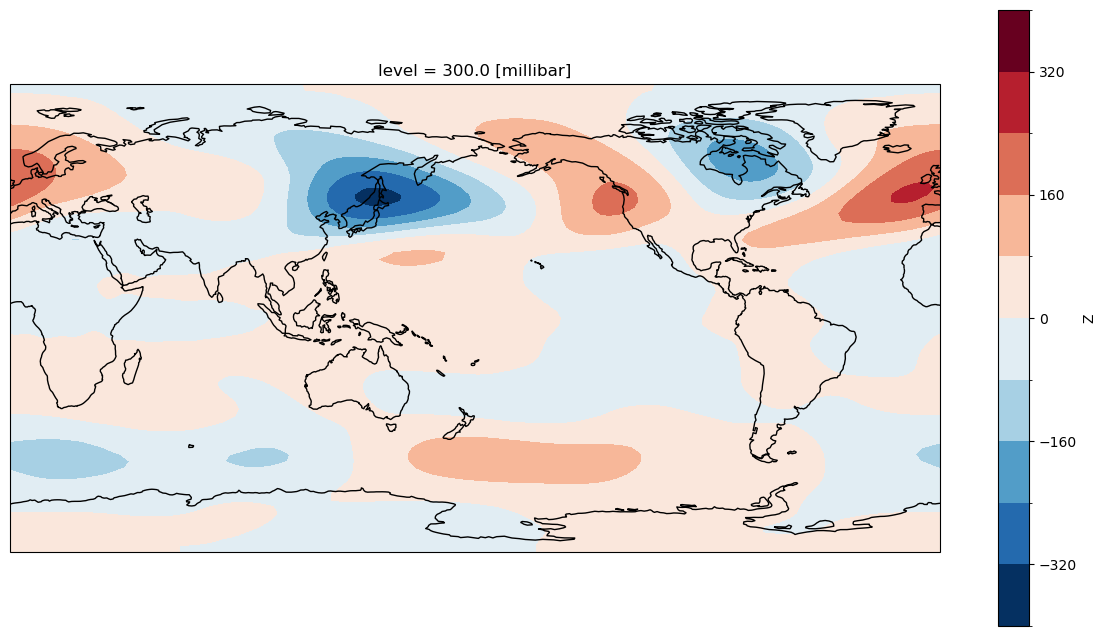

In [94]:
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
Phiprime.sel(level=300).plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=11, cmap = 'RdBu_r')
ax.coastlines()

Text(0.5, 1.0, 'Streamfunction 300hPa NCEP-NCAR 1948-1999 Jan')

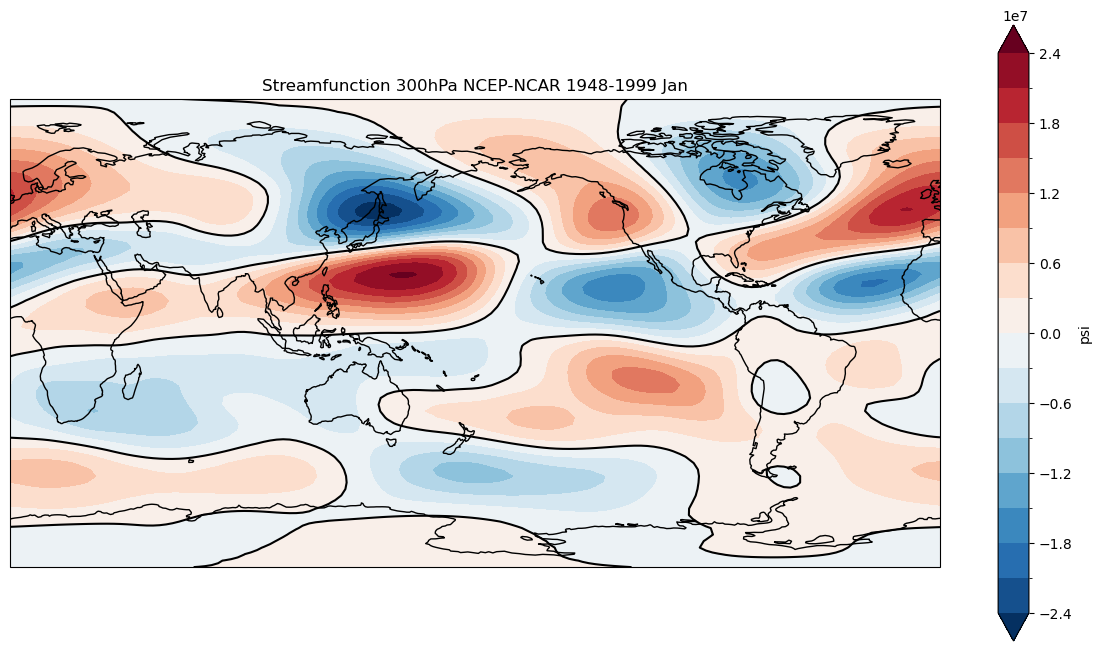

In [100]:
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = (helmhotz.psi - helmhotz.psi.mean('lon'))
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r')
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()
ax.set_title("Streamfunction 300hPa NCEP-NCAR 1948-1999 Jan")

# Stationary wave model

In [23]:
SNAPSHOTS_DIR = '/net/helium/atmosdyn/qnicolas/stationarywave_snapshots/'
#snapshot_id = 'stationarywave_12level_T32_held2002_allforcings_linear_newtimescales'
snapshot_id = 'stationarywave_12level_T32_held2002_emfd_linear_nosfcemfd'
held = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
held = concat_levels(held ,12)
held

<xarray.Dataset> Size: 311MB
Dimensions:       (t: 121, longitude: 64, latitude: 32, sigma: 12, : 2,
                   sigma_stag: 11)
Coordinates: (12/13)
    phi           (longitude) float64 512B 0.0 0.09817 0.1963 ... 6.087 6.185
    theta         (latitude) float64 256B 3.068 2.972 2.875 ... 0.1698 0.07399
  * t             (t) float64 968B 0.0 6.0 12.0 18.0 ... 702.0 708.0 714.0 720.0
    sim_time      (t) float64 968B 0.0 6.0 12.0 18.0 ... 702.0 708.0 714.0 720.0
    wall_time     (t) float64 968B 396.5 420.2 425.5 ... 1.001e+03 1.004e+03
    timestep      (t) float64 968B 0.1111 0.1111 0.1111 ... 0.1111 0.1111 0.1111
    ...            ...
    write_number  (t) int64 968B 1 2 3 4 5 6 7 8 ... 115 116 117 118 119 120 121
  * longitude     (longitude) float64 512B -180.0 -174.4 -168.7 ... 168.7 174.4
  * latitude      (latitude) float64 256B -85.76 -80.27 -74.74 ... 80.27 85.76
    day           (t) float64 968B 0.0 0.25 0.5 0.75 ... 29.25 29.5 29.75 30.0
  * sigma         (sigma) float64 96B 0.04167 0.125 0.2083 ... 0.875 0.9583
  * sigma_stag    (sigma_stag) float64 88B 0.08333 0.1667 0.25 ... 0.8333 0.9167
Dimensions without coordinates: 
Data variables: (12/13)
    Phisfc        (t, longitude, latitude) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0
    lnps          (t, longitude, latitude) float64 2MB 0.0 0.0 ... 0.001389
    lnpsbar       (t, longitude, latitude) float64 2MB -0.3087 -0.2344 ... nan
    EHFD          (t, longitude, latitude, sigma) float64 24MB 0.0 0.0 ... 0.0
    EMFD          (t, , longitude, latitude, sigma) float64 48MB 0.0 ... -2.2...
    Qdiab         (t, longitude, latitude, sigma) float64 24MB 0.0 0.0 ... 0.0
    ...            ...
    Tbar          (t, longitude, latitude, sigma) float64 24MB 235.3 ... nan
    u             (t, , longitude, latitude, sigma) float64 48MB 0.0 ... 0.04808
    ubar          (t, , longitude, latitude, sigma) float64 48MB -1.068 ... nan
    zeta          (t, longitude, latitude, sigma) float64 24MB 0.0 ... -2.437...
    sigmadot      (t, longitude, latitude, sigma_stag) float64 22MB 0.0 ... -...
    sigmadotbar   (t, longitude, latitude, sigma_stag) float64 22MB -2.276e-1...

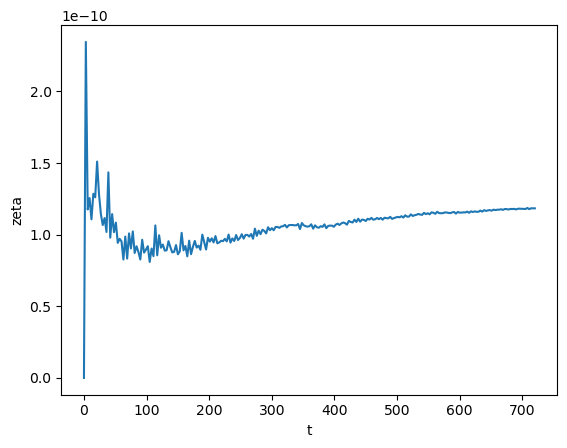

In [145]:
# CONVERGENCE
(held.zeta**2).mean(('longitude','latitude','sigma')).plot()

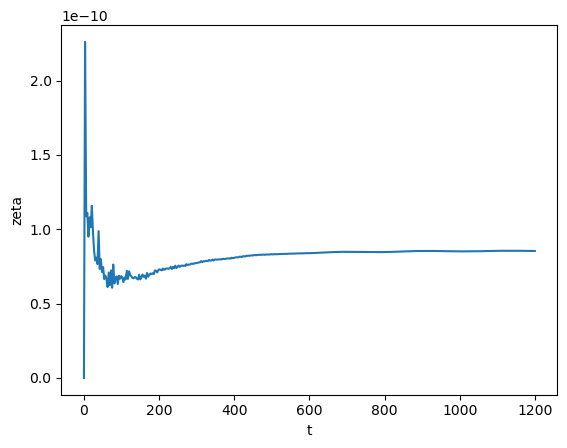

In [ ]:
# CONVERGENCE
(held.zeta**2).mean(('longitude','latitude','sigma')).plot()

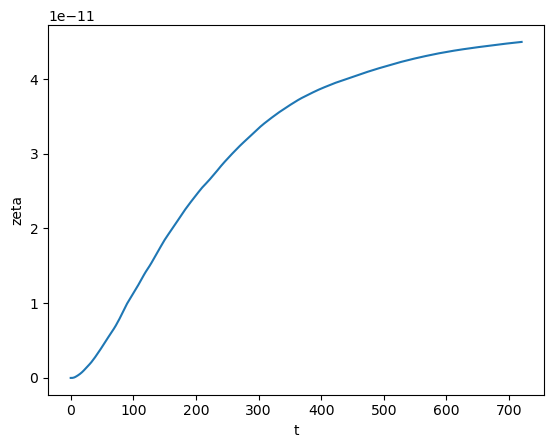

In [ ]:
# CONVERGENCE - diab/ehfd only
(held.zeta**2).mean(('longitude','latitude','sigma')).plot()

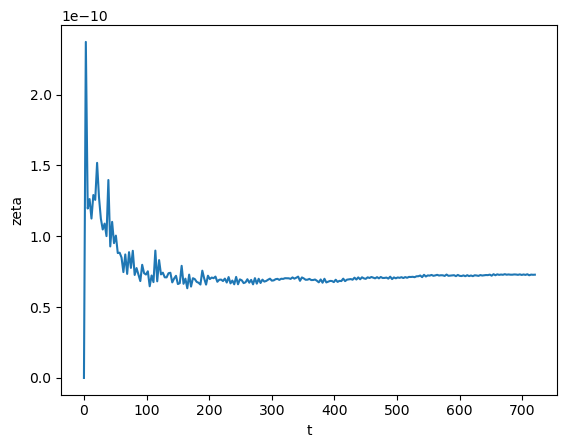

In [ ]:
# CONVERGENCE - orog only
(held.zeta**2).mean(('longitude','latitude','sigma')).plot()

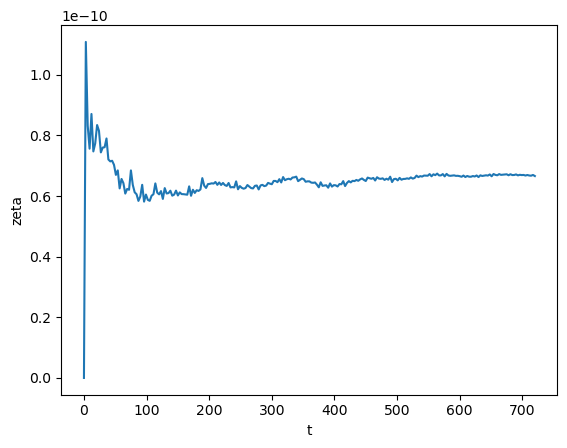

In [5]:
# CONVERGENCE - orogno zonal mean only
(held.zeta**2).mean(('longitude','latitude','sigma')).plot()

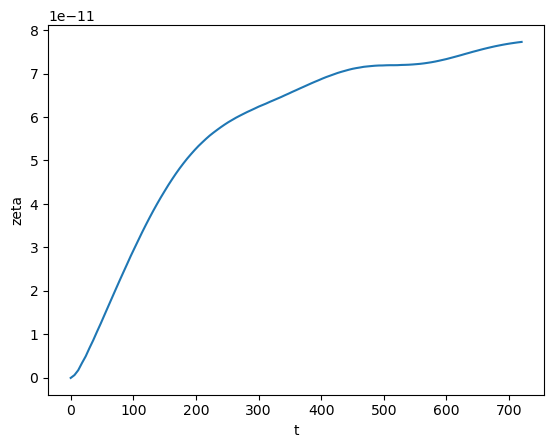

In [ ]:
# CONVERGENCE - diab/ehfd only - 24 levs
(held.zeta**2).mean(('longitude','latitude','sigma')).plot()

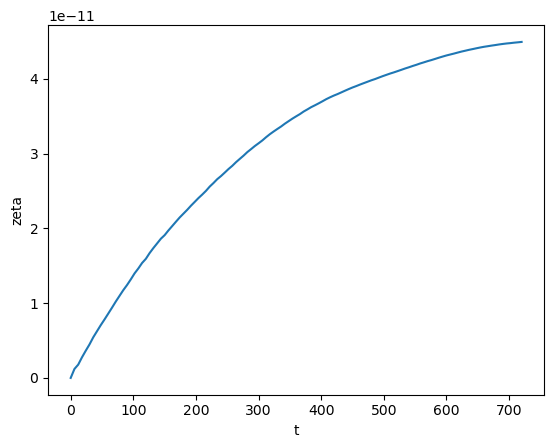

In [19]:
# CONVERGENCE - emfd only
(held.zeta**2).mean(('longitude','latitude','sigma')).plot()

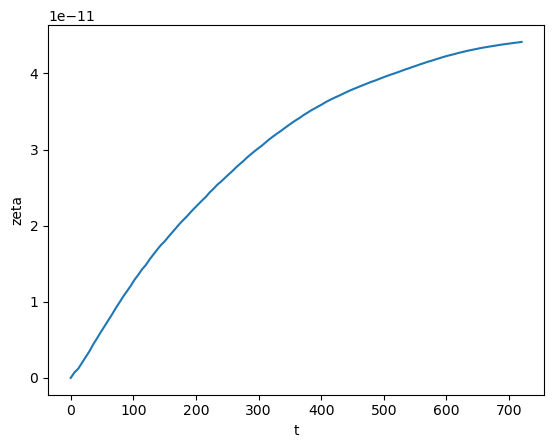

In [24]:
# CONVERGENCE - emfd only - no sfc emfd
(held.zeta**2).mean(('longitude','latitude','sigma')).plot()

In [25]:
held_mean = held.sel(t=slice(600,720)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

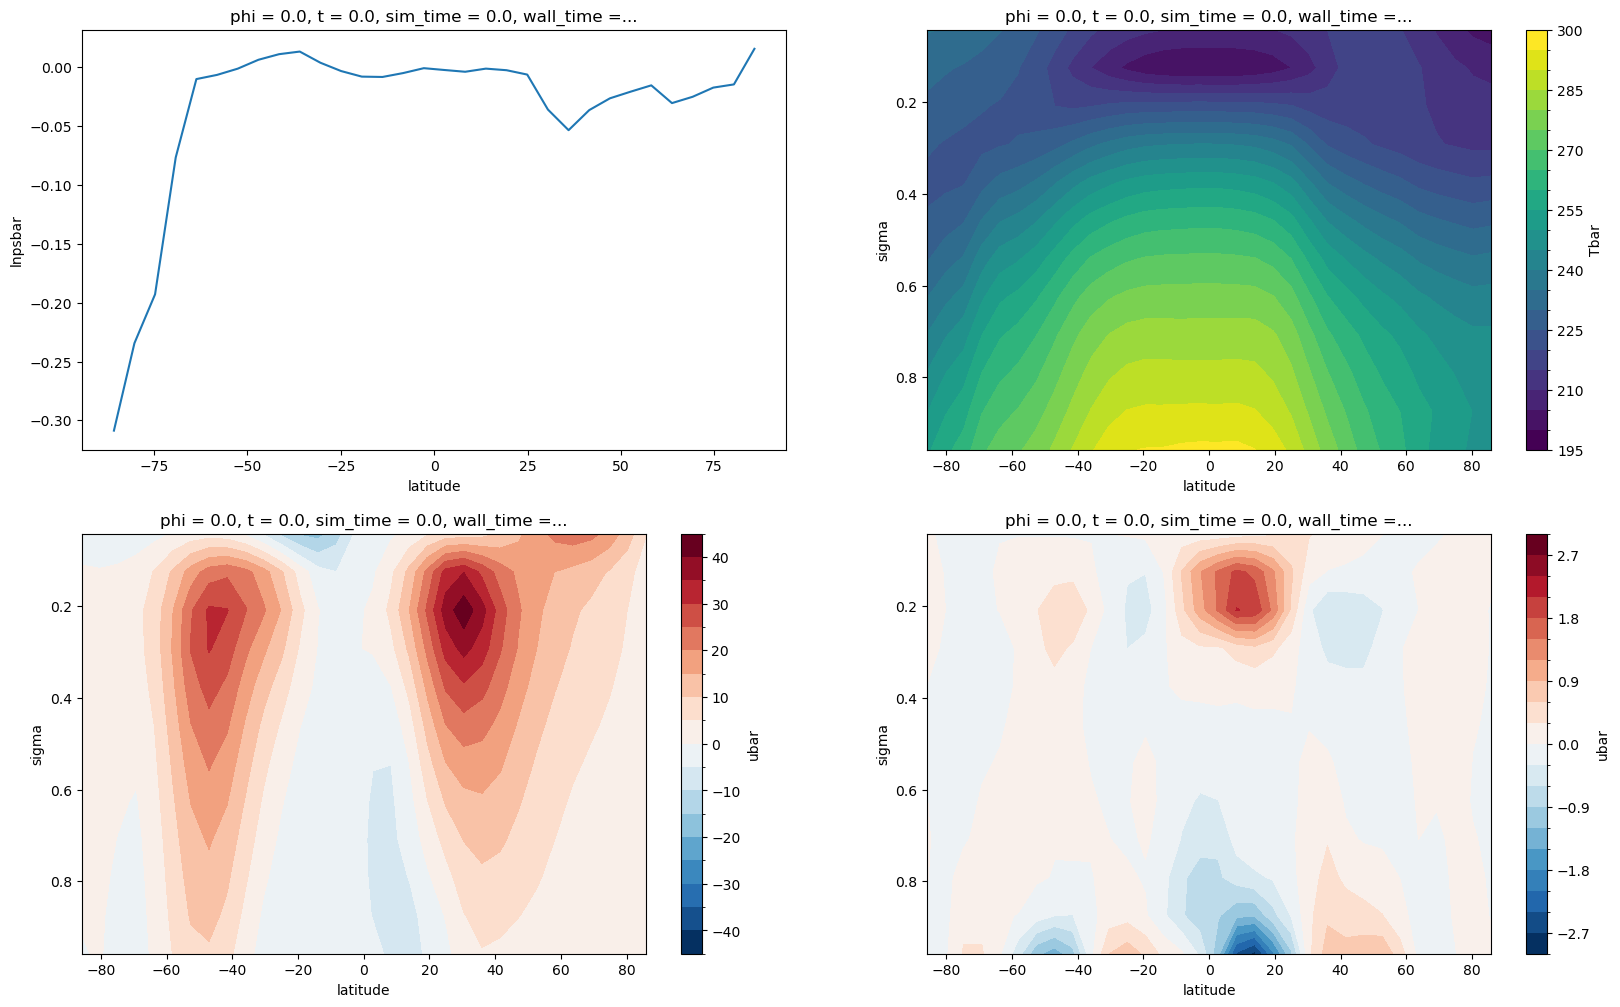

In [136]:
# basic state
_,axs = plt.subplots(2,2,figsize=(20,12)); axs=axs.reshape(-1)
held_init = held.isel(t=0,longitude=0)
for i,(ax,var) in enumerate(zip(axs,(held_init.lnpsbar,held_init.Tbar,held_init.ubar[0],-held_init.ubar[1]))):
    if i==0:
        var.plot(ax=ax)
    else:
        var.plot.contourf(ax=ax,y='sigma',yincrease=False,levels=21)

In [26]:
helm = calc_helmholtz(held_mean.u)
helm = helm.assign_coords(pressure=helm.sigma * SP.rename(lat = 'latitude',lon = 'longitude').interp_like(helm) / 100)
helm_300 = xr.apply_ufunc(lambda sig,y : np.interp(300.,sig,y),
                           helm.pressure,
                           helm,
                           input_core_dims=(('sigma',),('sigma',)),
                           vectorize=True)

2025-06-26 11:24:28,627 subsystems 0/1 INFO :: Building subproblem matrices 1/31 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2025-06-26 11:24:28,645 subsystems 0/1 INFO :: Building subproblem matrices 4/31 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2025-06-26 11:24:28,669 subsystems 0/1 INFO :: Building subproblem matrices 8/31 (~26%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-06-26 11:24:28,693 subsystems 0/1 INFO :: Building subproblem matrices 12/31 (~39%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2025-06-26 11:24:28,717 subsystems 0/1 INFO :: Building subproblem matrices 16/31 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2025-06-26 11:24:28,740 subsystems 0/1 INFO :: Building subproblem matrices 20/31 (~65%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2025-06-26 11:24:28,764 subsystems 0/1 INFO :: Building subproblem matrices 24/31 (~77%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2025-06-26 11:24:28,788 subsystems 0/1 INFO :: Building subproblem matric

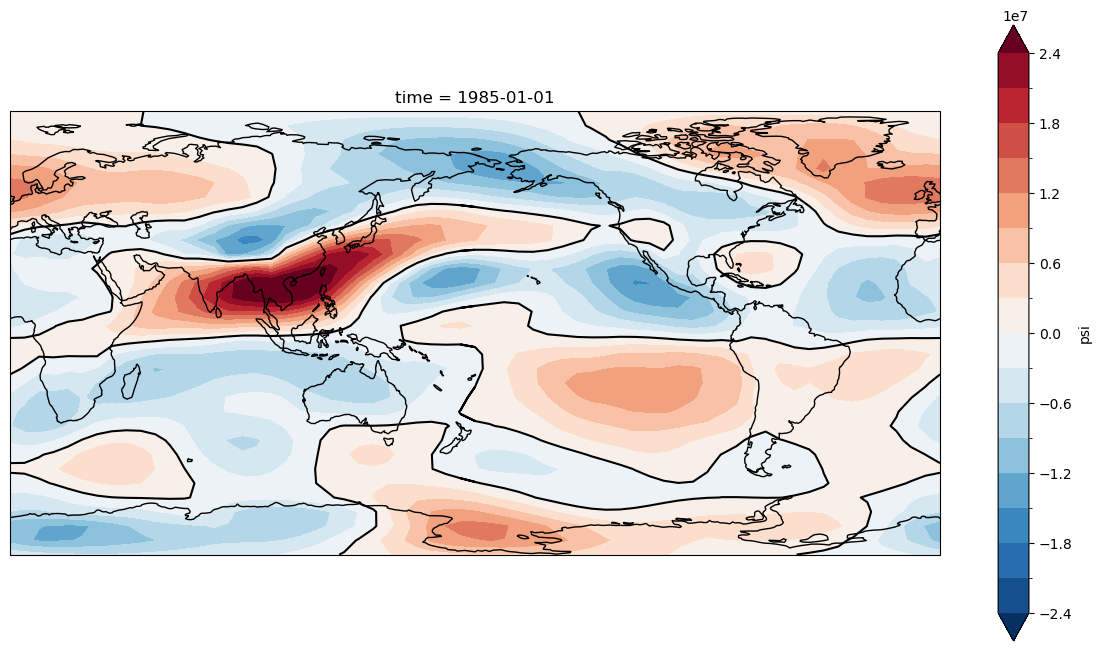

In [ ]:
# all forcings, new damping
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

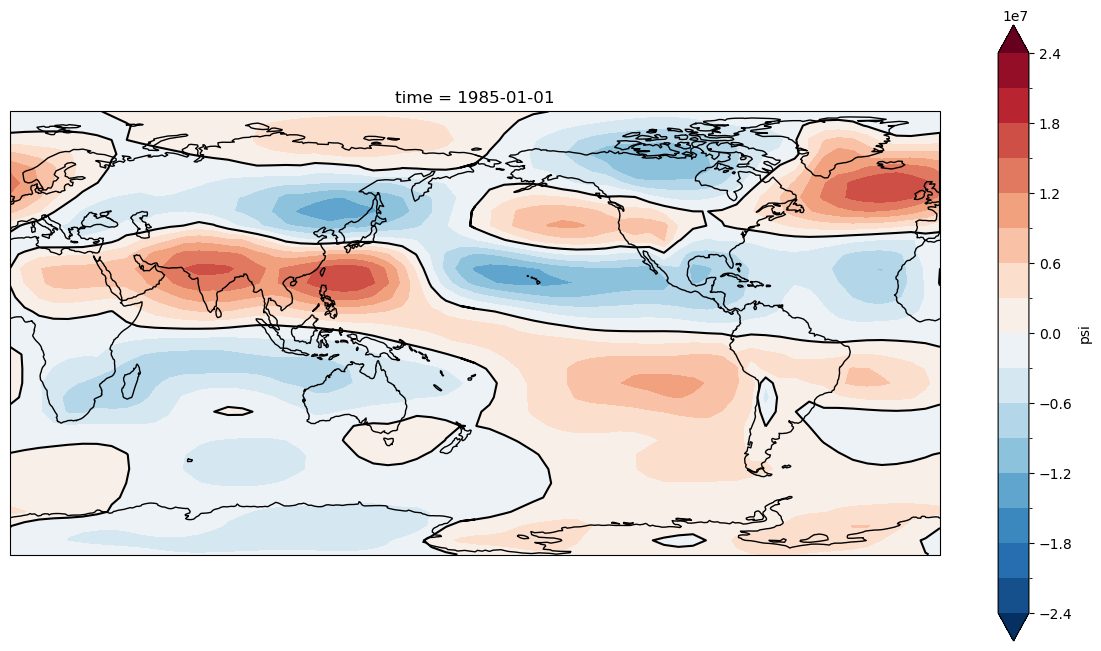

In [ ]:
# only heating forcings, with zonal mean, new damping

_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

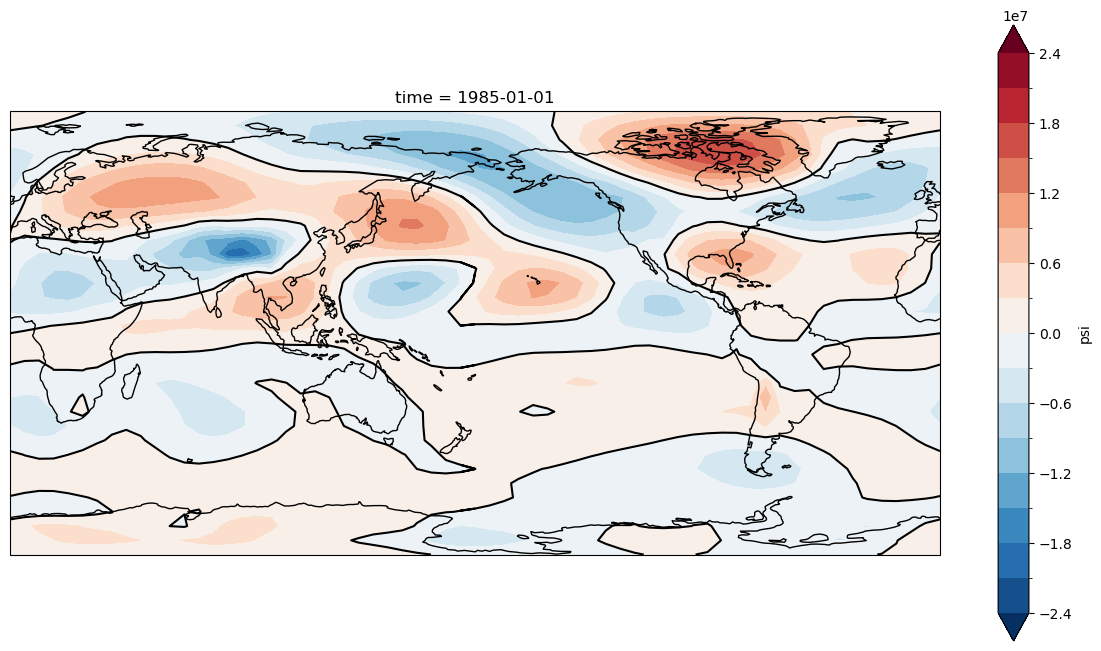

In [22]:
# only emfd forcings, with zonal mean, new damping

_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

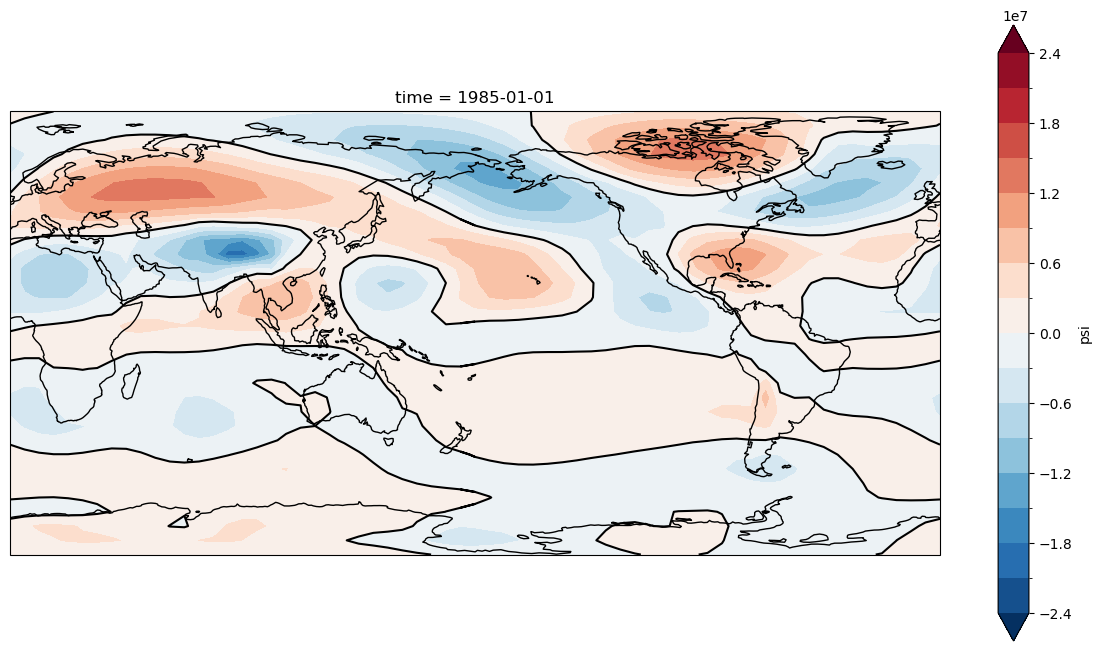

In [27]:
# only emfd forcings with no sfc emfd, with zonal mean, new damping

_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

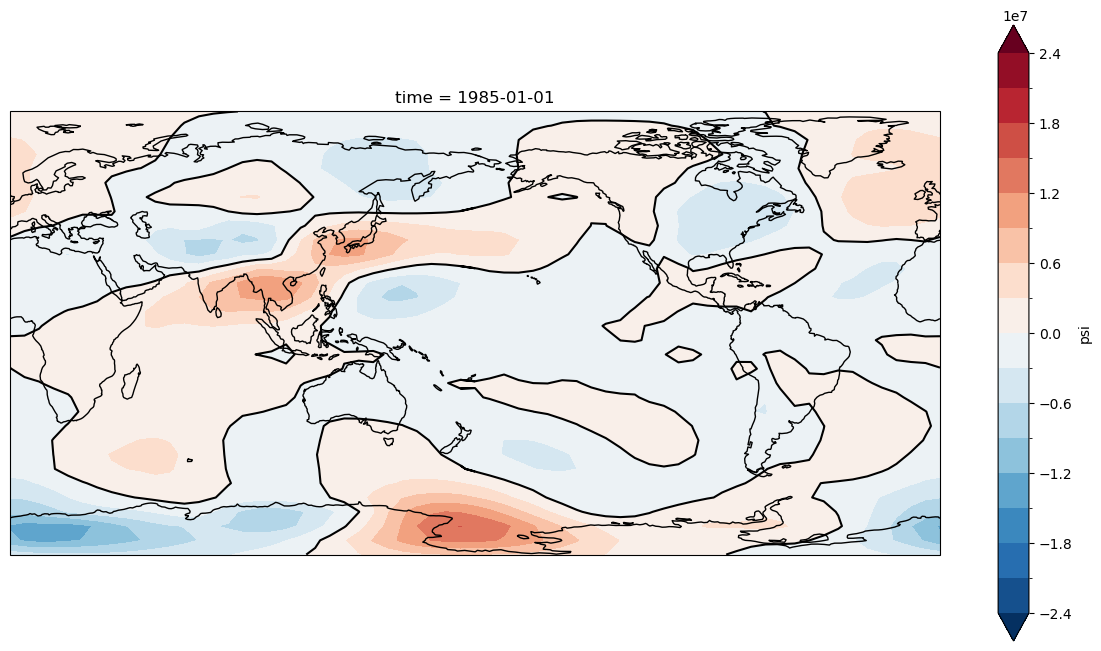

In [160]:
# only topo forcing, new damping

_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

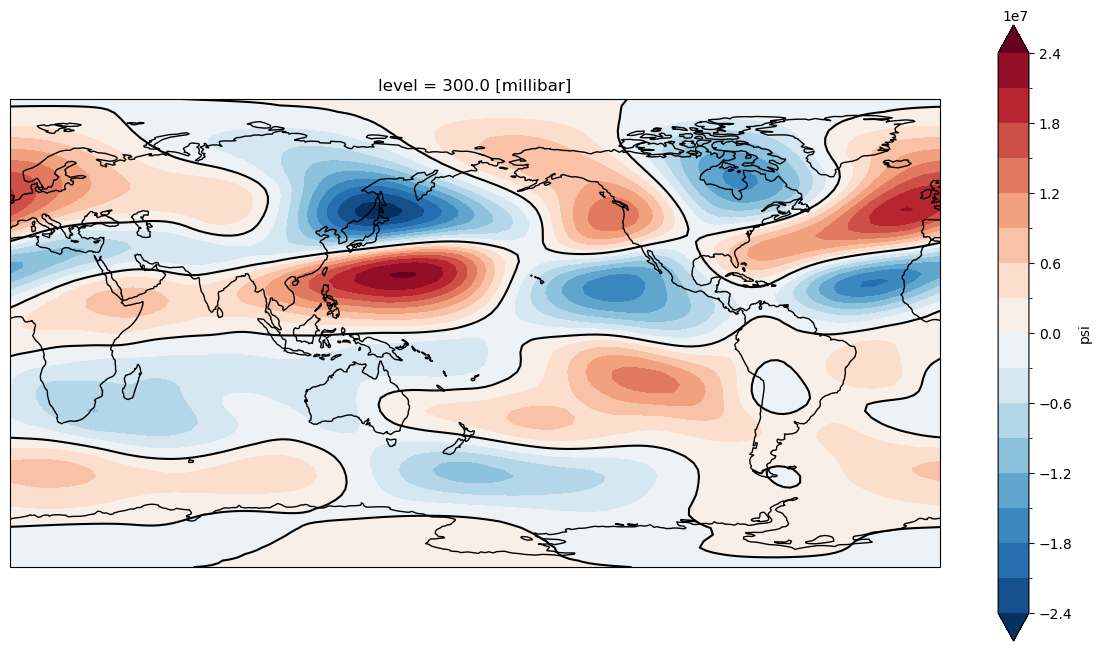

In [101]:
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = (helmhotz.psi - helmhotz.psi.mean('lon'))
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r')
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

In [118]:
test = xr.open_dataset("stationaryWave/ncep_jan_forcings.nc")

Text(0.5, 1.0, 'Qdiab diagnosed from NCEP as a residual of the thermo eqn')

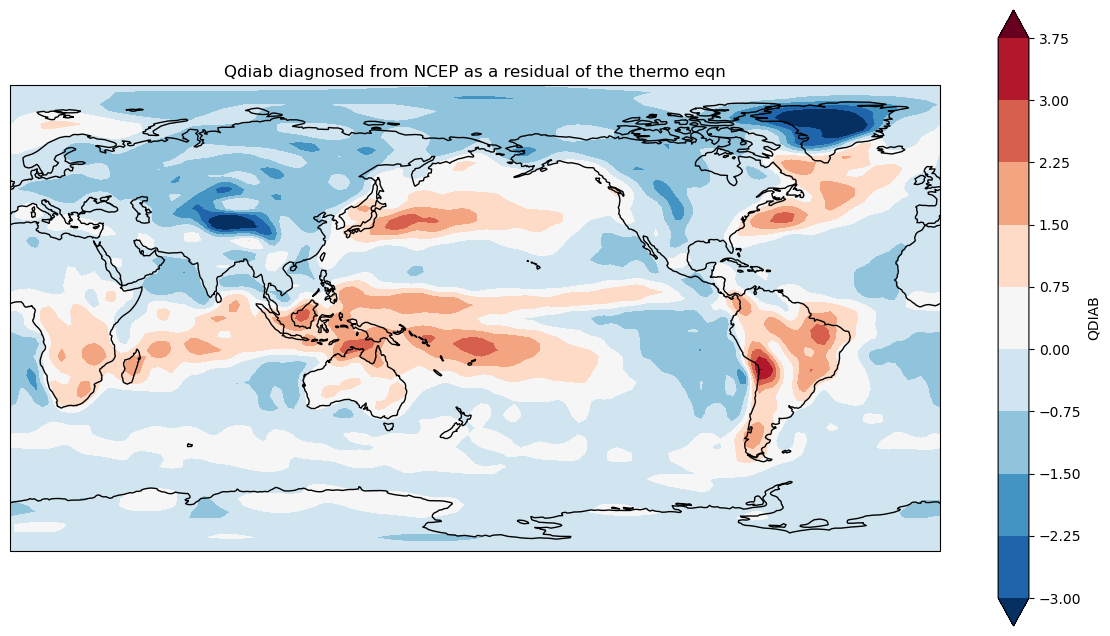

In [8]:
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
wrap_lon(test.QDIAB.integrate('pressure') * 86400 / 990).plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-3,3.76,0.75), cmap = 'RdBu_r',extend='both')
ax.coastlines()
ax.set_title("Qdiab diagnosed from NCEP as a residual of the thermo eqn")

# Sum of linear responses to individual forcings

In [29]:

snapshot_ids = ['stationarywave_12level_T32_held2002_emfd_linear_nosfcemfd',
                'stationarywave_12level_T32_held2002_diabehfd_linear',
                'stationarywave_12level_T32_held2002_orog_linear',]
held = 0
for snapshot_id in snapshot_ids:
    temp = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
    temp = concat_levels(temp ,12)
    held = held+temp

In [31]:
held_mean = held.sel(t=slice(600,720)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

In [32]:
helm = calc_helmholtz(held_mean.u)
helm = helm.assign_coords(pressure=helm.sigma * SP.rename(lat = 'latitude',lon = 'longitude').interp_like(helm) / 100)
helm_300 = xr.apply_ufunc(lambda sig,y : np.interp(300.,sig,y),
                           helm.pressure,
                           helm,
                           input_core_dims=(('sigma',),('sigma',)),
                           vectorize=True)

2025-06-26 11:30:28,134 subsystems 0/1 INFO :: Building subproblem matrices 1/31 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2025-06-26 11:30:28,152 subsystems 0/1 INFO :: Building subproblem matrices 4/31 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2025-06-26 11:30:28,175 subsystems 0/1 INFO :: Building subproblem matrices 8/31 (~26%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2025-06-26 11:30:28,200 subsystems 0/1 INFO :: Building subproblem matrices 12/31 (~39%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2025-06-26 11:30:28,224 subsystems 0/1 INFO :: Building subproblem matrices 16/31 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2025-06-26 11:30:28,247 subsystems 0/1 INFO :: Building subproblem matrices 20/31 (~65%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2025-06-26 11:30:28,272 subsystems 0/1 INFO :: Building subproblem matrices 24/31 (~77%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2025-06-26 11:30:28,295 subsystems 0/1 INFO :: Building subproblem matric

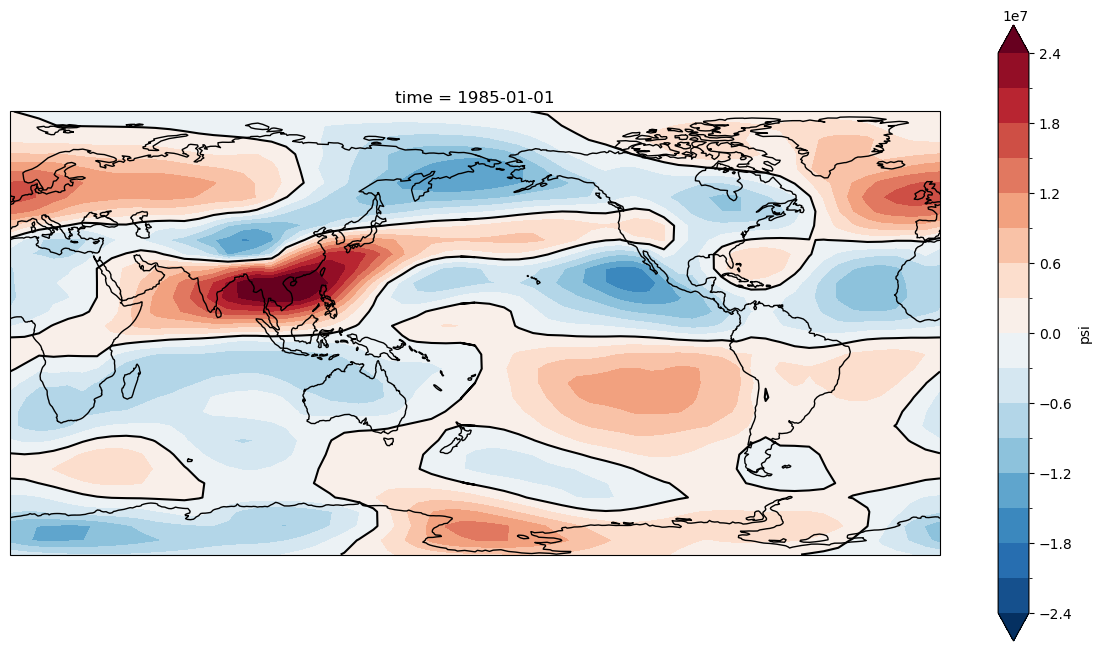

In [ ]:
# all forcings (as a sum; emfd at the surface zeroed out), new damping
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

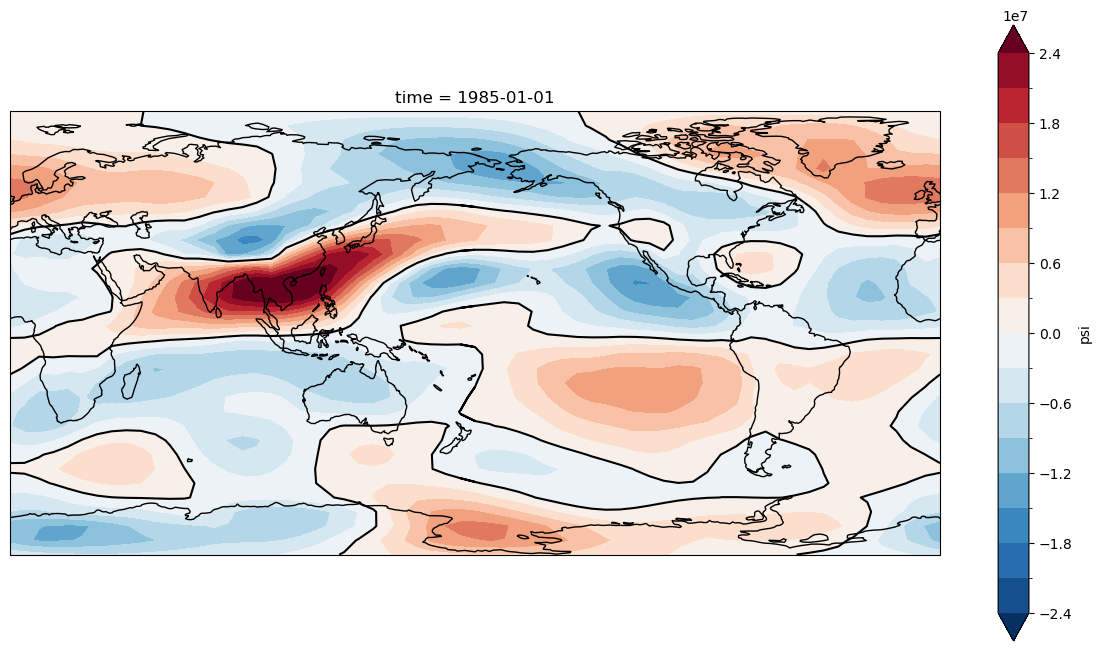

In [ ]:
# all forcings, new damping
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

# Response to orography

<GeoAxes: title={'center': 'time = 1985-01-01'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

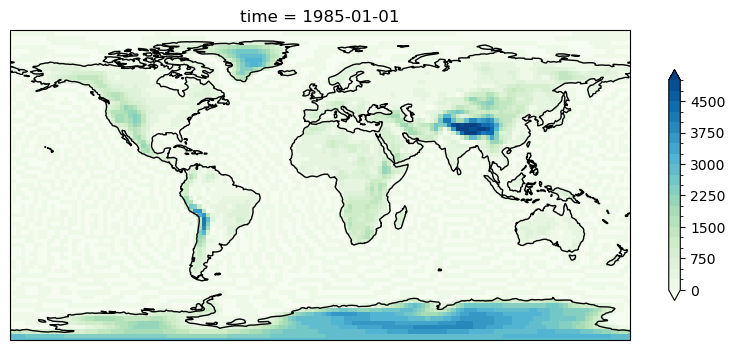

In [60]:
forcings = xr.open_dataset("stationaryWave/ncep_jan_forcings.nc")
quickplot(forcings.ZSFC,levels = np.linspace(0,5000,21))

<GeoAxes: title={'center': 'time = 1985-01-01'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

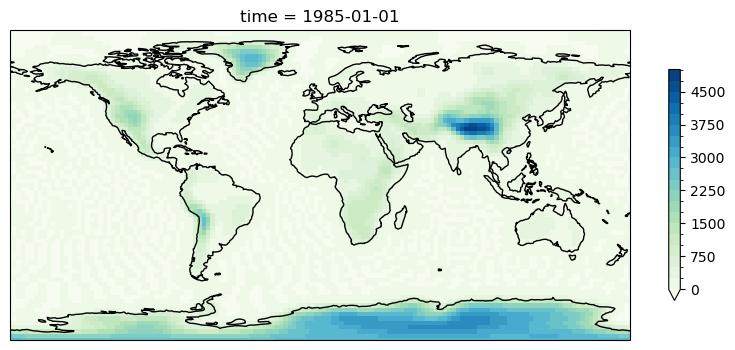

In [61]:
from scipy.ndimage import gaussian_filter
forcings['ZSFC'][:] = gaussian_filter(forcings['ZSFC'].data,sigma=1)
quickplot(forcings.ZSFC,levels = np.linspace(0,5000,21))

In [72]:
snapshot_id = 'stationarywave_12level_T32_held2002_idealtibet_linear'
held = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
held = concat_levels(held ,12)


In [73]:
held_mean = held.sel(t=slice(600,720)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

In [74]:
helm = calc_helmholtz(held_mean.u)
helm = helm.assign_coords(pressure=helm.sigma * SP.rename(lat = 'latitude',lon = 'longitude').interp_like(helm) / 100)
helm_300 = xr.apply_ufunc(lambda sig,y : np.interp(300.,sig,y),
                           helm.pressure,
                           helm,
                           input_core_dims=(('sigma',),('sigma',)),
                           vectorize=True)

2025-06-26 14:20:04,671 subsystems 0/1 INFO :: Building subproblem matrices 1/31 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+01/s
2025-06-26 14:20:04,692 subsystems 0/1 INFO :: Building subproblem matrices 4/31 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2025-06-26 14:20:04,718 subsystems 0/1 INFO :: Building subproblem matrices 8/31 (~26%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2025-06-26 14:20:04,745 subsystems 0/1 INFO :: Building subproblem matrices 12/31 (~39%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2025-06-26 14:20:04,773 subsystems 0/1 INFO :: Building subproblem matrices 16/31 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2025-06-26 14:20:04,799 subsystems 0/1 INFO :: Building subproblem matrices 20/31 (~65%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2025-06-26 14:20:04,826 subsystems 0/1 INFO :: Building subproblem matrices 24/31 (~77%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2025-06-26 14:20:04,853 subsystems 0/1 INFO :: Building subproblem matric

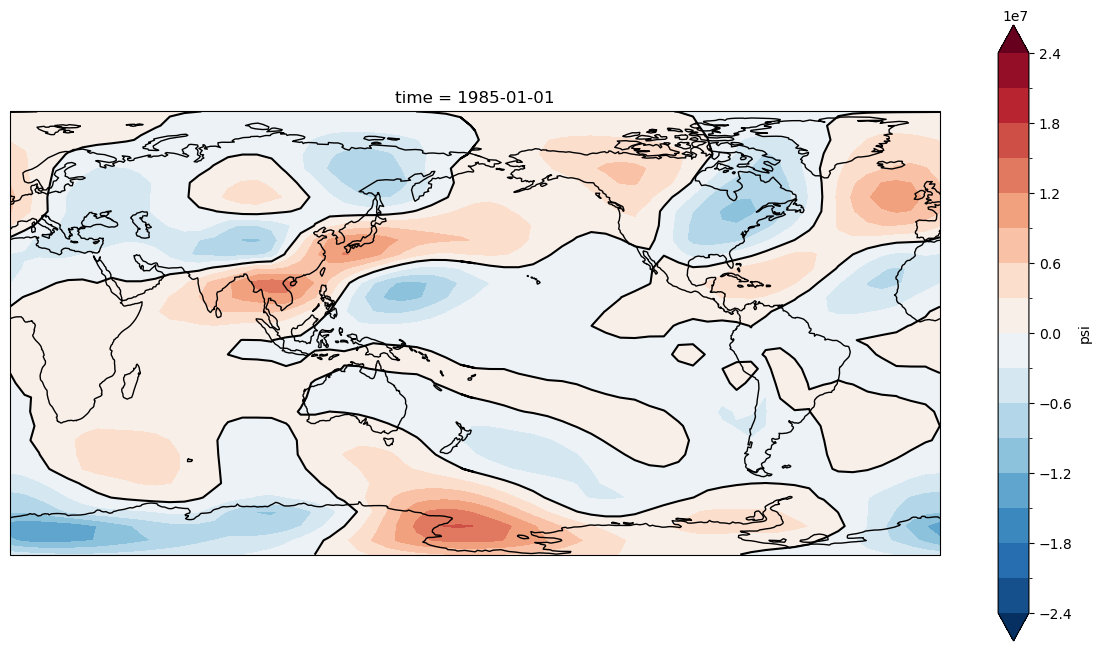

In [ ]:
# orog forcing, 24 levs, unchanged damping
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

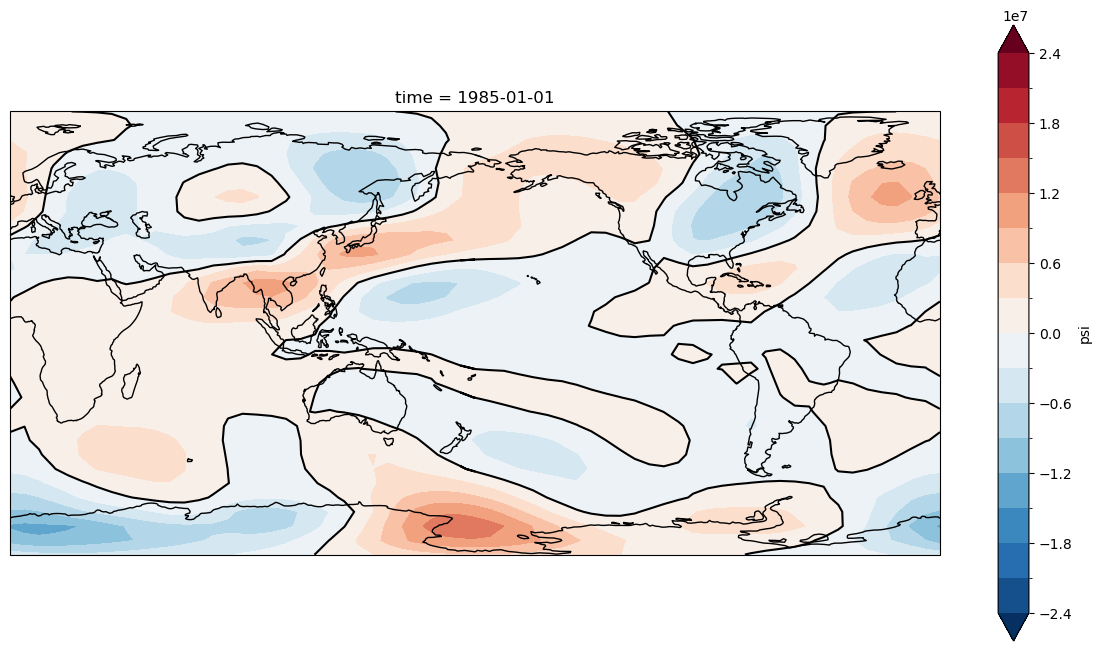

In [ ]:
# smoothed orog forcing, 24 levs, unchanged damping
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

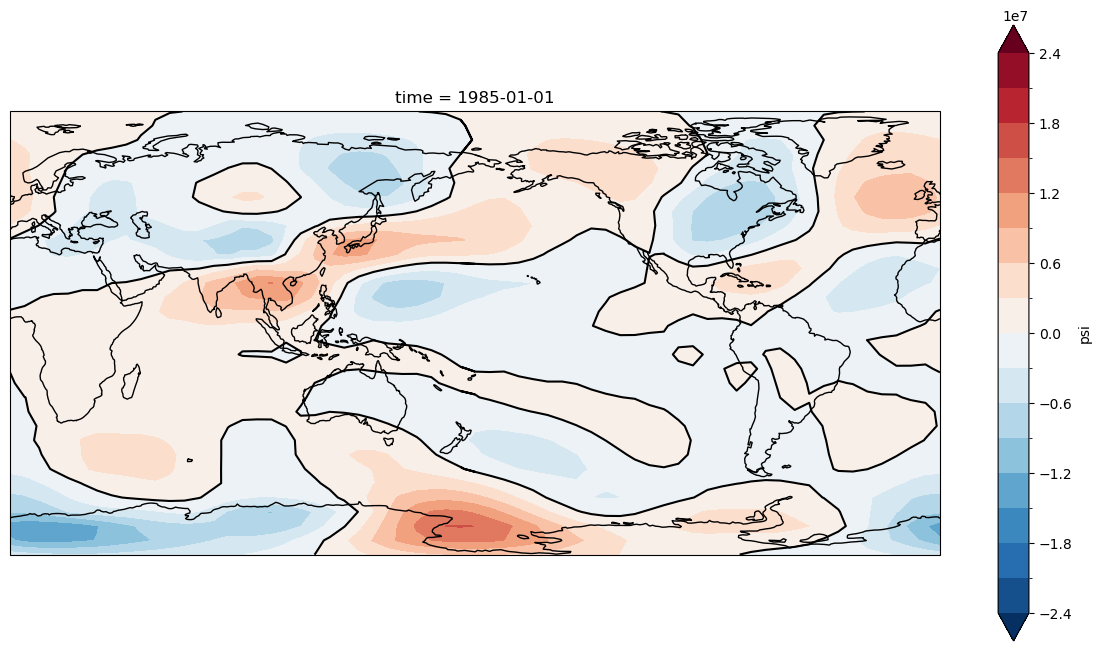

In [58]:
# smoothed orog forcing, 24 levs, adapted damping
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

<GeoAxes: title={'center': 'time = 1985-01-01'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

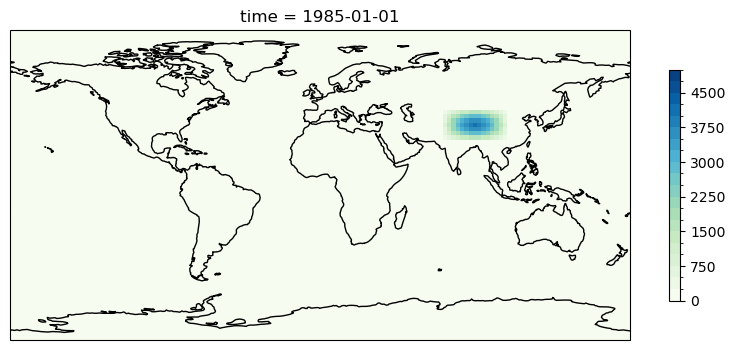

In [ ]:
costrunc = lambda x,x0,sig : np.cos((x-x0)/sig * np.pi/2) * (np.abs(x-x0) < sig)
forcings['ZSFC'] = 4000 * costrunc(forcings.lat,35,10) * costrunc(forcings.lon,90,20)
quickplot(forcings.ZSFC,levels = np.linspace(0,5000,21))

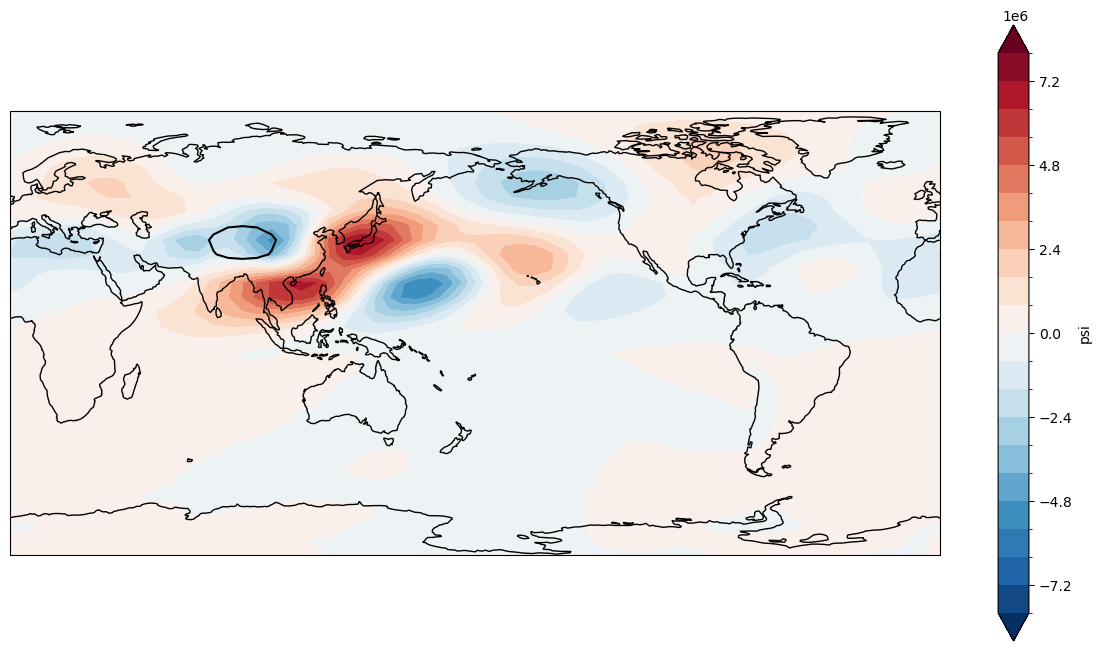

In [78]:
# ideal tibet
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = wrap_lon(helm_300.psi)
psiprime = psiprime - psiprime.mean('longitude')
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=21, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
#psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
(held_mean.Phisfc / 9.81).plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[2000.], colors = 'k')
ax.coastlines()

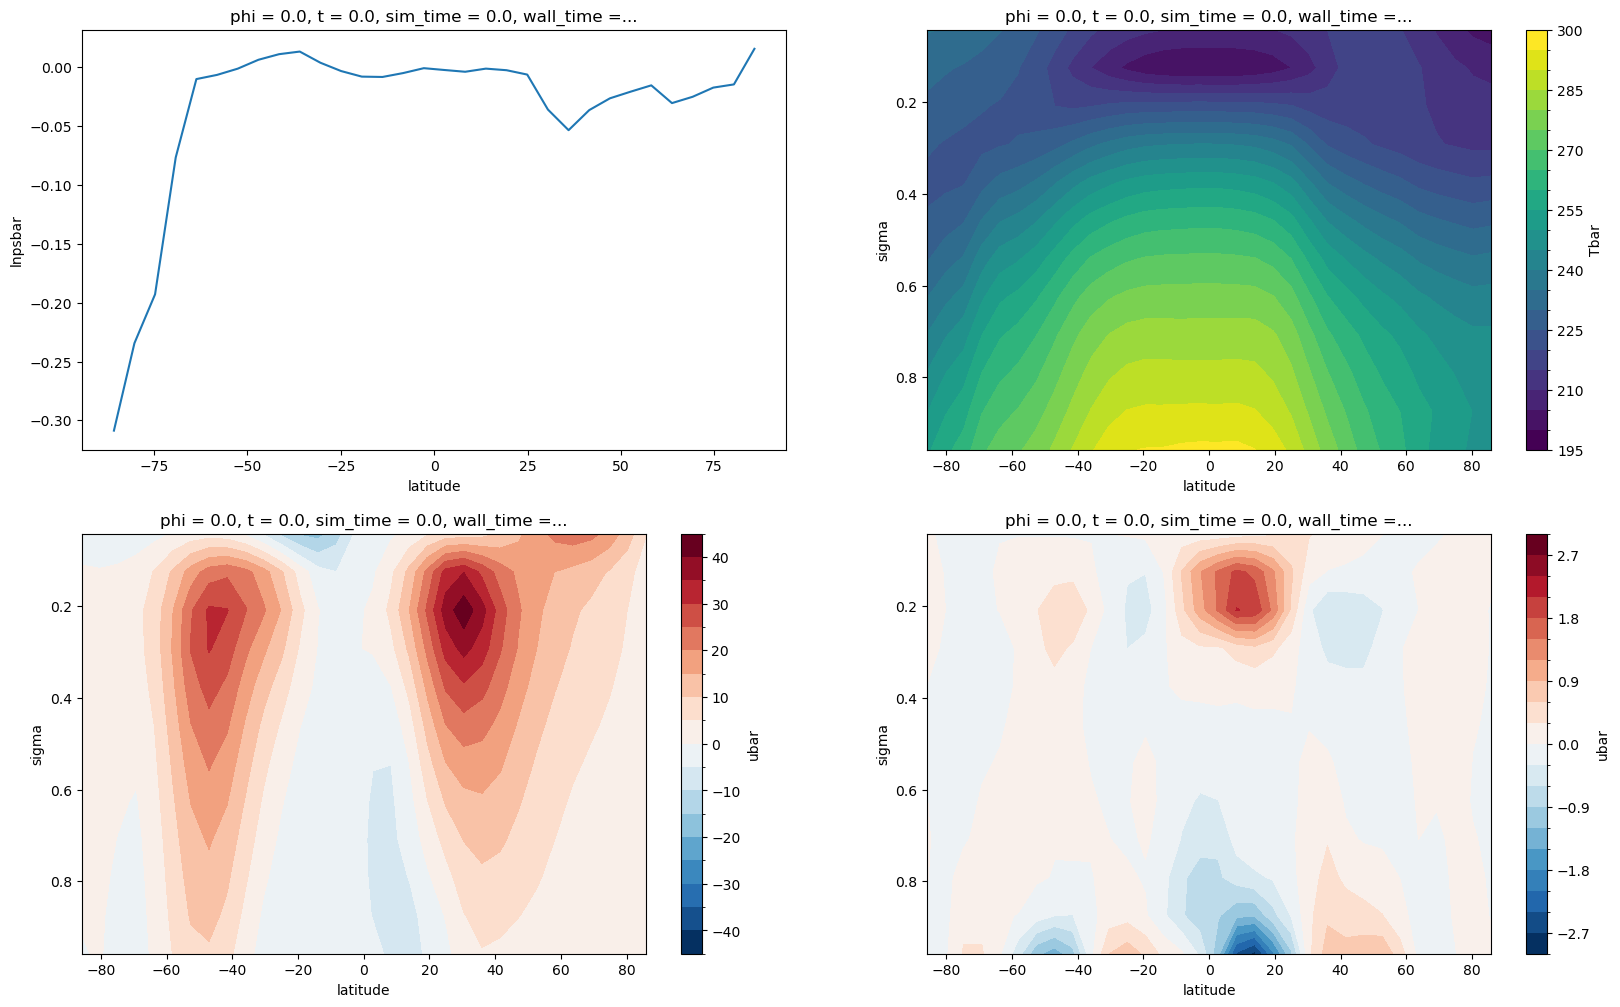

In [76]:
# basic state
_,axs = plt.subplots(2,2,figsize=(20,12)); axs=axs.reshape(-1)
held_init = held.isel(t=0,longitude=0)
for i,(ax,var) in enumerate(zip(axs,(held_init.lnpsbar,held_init.Tbar,held_init.ubar[0],-held_init.ubar[1]))):
    if i==0:
        var.plot(ax=ax)
    else:
        var.plot.contourf(ax=ax,y='sigma',yincrease=False,levels=21)

In [54]:
(np.arange(24)+0.5)/24

array([0.02083333, 0.0625    , 0.10416667, 0.14583333, 0.1875    ,
       0.22916667, 0.27083333, 0.3125    , 0.35416667, 0.39583333,
       0.4375    , 0.47916667, 0.52083333, 0.5625    , 0.60416667,
       0.64583333, 0.6875    , 0.72916667, 0.77083333, 0.8125    ,
       0.85416667, 0.89583333, 0.9375    , 0.97916667])